# MLOPS : Define the optimal retrain frequency

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as st
from sklearn.decomposition import PCA
from sklearn import preprocessing as pp

from datetime import date
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

from sklearn.cluster import KMeans as km
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

pd.set_option('display.max_columns', None)

2023-08-01 14:11:02.561889: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-01 14:11:02.709461: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-01 14:11:02.710139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 14:11:03.671857: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('datasets/cleaned.csv')
print(df.columns)
print(df.shape)

Index(['order_purchase_timestamp_str', 'order_purchase_timestamp',
       'customer_code', 'price', 'payment_value', 'review_score',
       'freight_value', 'frequency', 'since_last_purchase'],
      dtype='object')
(115609, 9)


## Preparation Periodic DataFrame

In [3]:
list_of_df = list()
# Set the Index to be the Date
df['Date'] = pd.to_datetime(df['order_purchase_timestamp'], format='%Y/%m/%d')
df.set_index('Date', inplace=True)

# Sort the Data
df = df.sort_values('order_purchase_timestamp')

From = pd.to_datetime('2017-01-01')
To   = pd.to_datetime('2017-12-31')
X0 = df.loc[From:To,:].reset_index(level=0)
X0 =X0.drop(['Date','order_purchase_timestamp_str','order_purchase_timestamp'],axis=1)

year=2018
for month in range(1,12):
# Slice the Data
    From = pd.to_datetime(str(year)+'-'+str(month)+'-1')
    if year==2016 and month == 2:
        To   = pd.to_datetime(str(year)+'-'+str(month)+'-29')
    elif month == 2:
        To   = pd.to_datetime(str(year)+'-'+str(month)+'-28')
    elif month > 1 and month < 7 and month%2 == 0 or month > 7 and month < 12 and month%2 == 1:
        To   = pd.to_datetime(str(year)+'-'+str(month)+'-30')
    else:
        To   = pd.to_datetime(str(year)+'-'+str(month)+'-31')
    df_element = df.loc[From:To,:].reset_index(level=0)
    if df_element.shape[0] != 0:
        list_of_df.append(df_element.drop(['Date','order_purchase_timestamp_str','order_purchase_timestamp'],axis=1))

list_of_df[0]

,customer_code,price,payment_value,review_score,freight_value,frequency,since_last_purchase
0,5923,148.0,184.36,5,36.36,1,2038.0
1,54080,151.2,169.51,5,18.31,1,2038.0
2,4131,43.2,55.05,5,11.85,1,2038.0
3,412,139.0,189.84,5,50.84,1,2038.0
4,51787,99.0,106.95,5,7.95,1,2038.0
...,...,...,...,...,...,...,...
8008,22218,49.0,74.63,5,25.63,1,2008.0
8009,48375,249.9,319.11,1,69.21,1,2008.0
8010,80893,49.0,65.79,4,16.79,1,2008.0
8011,41579,96.9,110.60,1,13.70,1,2008.0


## Functions

We create recurrent functions in order be able to call them in multiple situations. 

In this case we have the PCA to reduce the number of dimensions

In [4]:
def principalaxles(df):

    df = pp.StandardScaler().fit_transform(df)
    df = pd.DataFrame(data=df)
    pca = PCA()
    pca.fit(df)
    pca_data = pca.transform(df)
    per_var =  np.round(pca.explained_variance_ratio_*100, decimals = 1)
    labels =['PC' + str(x) for x in range(1, len(per_var)+1)]
    pca_df = pd.DataFrame(pca_data, columns=labels)
    
    return pca_df

The elbow method consists in calculating the variance for every number of clusters if applied to the data. Is is common practice for the KMeans Model to choose the number of clusters at the inflexion point (elbow) in the graph as the best tradeoff between variance and plausibility of the individual clusters

In [5]:
def elbow(method, X):
    tab = []
    r = range(1, 40)
    for i in tqdm(r):
        kmeans = km(n_clusters=i)
        kmeans.fit(X)
        tab.append(kmeans.inertia_)

    plt.plot(r, tab)
    plt.title('Elbow Method')
    plt.xlabel('Nb of Clusters')
    plt.ylabel('Inertia')
    plt.show()

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The adjusted Rand values range between -1 and 1. A score close to 0.0 indicates random assignments, and a score close to 1 indicates perfectly labeled clusters.

Method 1 - Single Fit, Multiple Predict: This method involves training the model once and then using this trained model to make predictions on new data as it comes in. This is essentially the traditional method of deploying a machine learning model in a production environment.
In the context of MLOps, this means that you would only need to train your model once, and then you could continuously deploy it to make predictions on new data. This can be more efficient in terms of computational resources, as you don't need to retrain your model every time you have new data. However, the downside is that your model may not adapt well if the new data differs significantly from the data it was trained on.

Method 2 - Monthly Fit and Predict: This method involves retraining the model every time new data comes in. This can be useful if your data is changing over time (a concept known as concept drift in machine learning), as it allows your model to adapt to the new data.
In an MLOps context, this method could involve setting up a pipeline that automatically retrains your model on a regular basis (e.g., every month, as suggested by the function name). This can help ensure that your model stays up-to-date with the latest data, but it can also be more computationally intensive, as you need to retrain your model regularly.

The Adjusted Rand Index (ARI) is then used to compare the results of these two methods. The ARI is a measure of the similarity between two data clusterings, taking into account chance groupings, and is often used in scenarios where the ground truth labels are not known.

This kind of comparison can be very useful in an MLOps context to understand how different approaches to model training and prediction can affect the performance of your machine learning models. By comparing the ARI scores, you can get an idea of whether retraining your model regularly (Method 2) offers any advantages over using a single, initially trained model (Method 1).

In [6]:
# def ari(model,X0,dflist):
#     m1 = []
#     m2 = []
#     score = []
#     df_ant = []
    
# #Method 1 - Single Fit, Multiple Predict
#     labels = model.fit(principalaxles(X0))
#     m1.append(labels)
#     df_ant = X0
#     for df in dflist[0:-1]:
#         df = df.append(df_ant)
#         pca_df = principalaxles(df)
#         if pca_df.shape[1] != 0:
#             d = model.predict(pca_df)
#             m1.append(d)
#             df_ant = df       
#     df_ant = []
    
# #Method 2 - Monthly Fit and Predict
#     labels = model.fit(principalaxles(X0))
#     m2.append(labels)
#     df_ant = X0
#     for df in dflist[:-1]:
#         df = df.append(df_ant)
#         if df.shape[1] != 0:
#             pca_df = principalaxles(df)
#             labels = model.fit(pca_df)
#             d = model.predict(pca_df)
#             m2.append(d)
#             df_ant = df
            
# #ARI
#     for i in range(1,len(m1)):
#         ari = str(i),adjusted_rand_score(m1[i], m2[i])

#         score.append(ari)
        
#     score=pd.DataFrame(data=score)


#     return score

In [7]:
def ari(model,X0,dflist):
    m1 = []
    m2 = []
    score = []
    df_ant = []
    
    # Method 1 - Single Fit, Multiple Predict
    labels = model.fit(principalaxles(X0))
    m1 = m1 + [labels]
    df_ant = X0
    for df in dflist[0:-1]:
        df = pd.concat([df, df_ant])
        pca_df = principalaxles(df)
        if pca_df.shape[1] != 0:
            d = model.predict(pca_df)
            m1 = m1 + [d]
            df_ant = df       
    df_ant = []
    
    # Method 2 - Monthly Fit and Predict
    labels = model.fit(principalaxles(X0))
    m2 = m2 + [labels]
    df_ant = X0
    for df in dflist[:-1]:
        df = pd.concat([df, df_ant])
        if df.shape[1] != 0:
            pca_df = principalaxles(df)
            labels = model.fit(pca_df)
            d = model.predict(pca_df)
            m2 = m2 + [d]
            df_ant = df
            
    # ARI
    for i in range(1,len(m1)):
        ari = (str(i), adjusted_rand_score(m1[i], m2[i]))
        score = score + [ari]
        
    score = pd.DataFrame(data=score)

    return score


In [8]:
def plot(X, labels):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels)
    ax.set_xlabel(X.columns[0])
    ax.set_ylabel(X.columns[1])
    plt.show()

## Calcul du ARI avec KMeans

In [9]:
#elbow(km(),list_of_df[0])
score_km = ari(km(n_clusters=3,random_state=1, n_init=10),X0,list_of_df)

<Axes: >

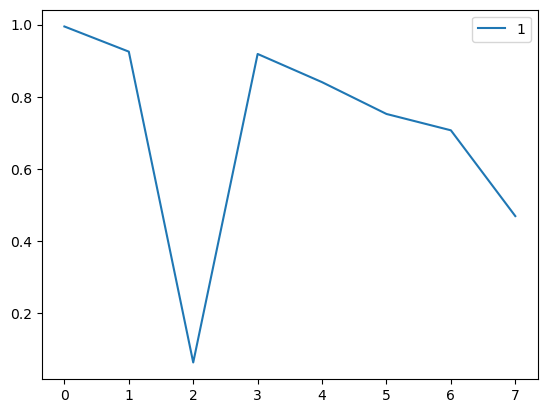

In [10]:
sns.lineplot(data=score_km)

As we can see the ARI crashes dramatically after 2 months. Meaning that it is considered optimal to retrain the data every 2 motnhs in order to get the best performance. 